In [142]:
!pip install tensorflow==2.17.1 opencv-python matplotlib

In [143]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [144]:
# tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [145]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [146]:
# paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [147]:
# directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [148]:
!tar -xf lfw.tgz

In [149]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)


In [150]:
import uuid

In [151]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\f9787e87-dda6-11ef-93de-c03532408c02.jpg'

In [152]:
for i in range(5): 
    cap = cv2.VideoCapture(i)
    if cap.isOpened():
        print(f"Webcam found at index {i}")
        cap.release()

Webcam found at index 0


In [153]:
# webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    frame = frame[120:120+250,200:200+250, :]
    
    # anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

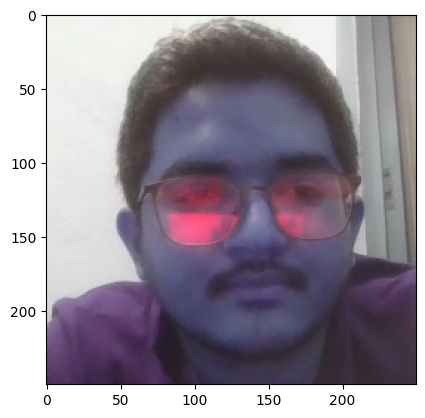

In [154]:
plt.imshow(frame[:250,:250, :])

In [155]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [156]:
dir_test = anchor.as_numpy_iterator()

In [157]:
print(dir_test.next())

b'data\\anchor\\12768d81-dce2-11ef-9268-c03532408c02.jpg'


In [158]:
def preprocess(file_path):
    
    byte_img = tf.io.read_file(file_path) 
    img = tf.io.decode_jpeg(byte_img)
    
    img = tf.image.resize(img, (100,100)) 
    img = img / 255.0
    
    return img

In [159]:
img = preprocess('data\\anchor\\11e9c20c-dce2-11ef-9981-c03532408c02.jpg')

In [160]:
img.numpy().max() 

0.9992647

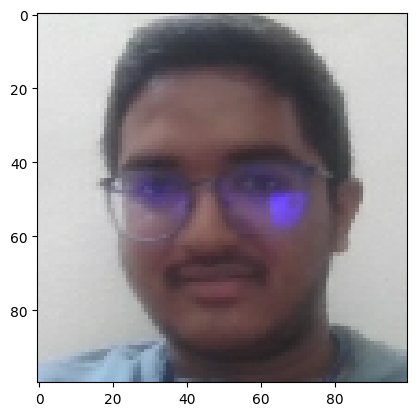

In [161]:
plt.imshow(img)

In [162]:
tf.ones(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [163]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [164]:
samples = data.as_numpy_iterator()

In [165]:
samples.next()

(b'data\\anchor\\0f6f6175-dce2-11ef-84a1-c03532408c02.jpg',
 b'data\\positive\\44cc860a-dce2-11ef-bbb0-c03532408c02.jpg',
 1.0)

In [166]:
exampple = samples.next()

In [167]:
exampple

(b'data\\anchor\\17032b86-dce2-11ef-b28f-c03532408c02.jpg',
 b'data\\positive\\4d16d47c-dce2-11ef-a599-c03532408c02.jpg',
 1.0)

In [168]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [169]:
res = preprocess_twin(*exampple)

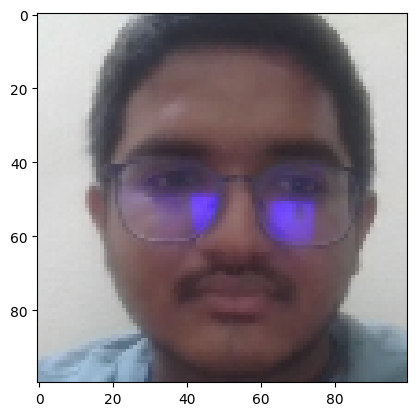

In [170]:
plt.imshow(res[1])

In [171]:
res[2]

1.0

In [172]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [173]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [174]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [175]:
inp = Input(shape=(100,100,3), name='input_image')

In [176]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [177]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [178]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [179]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [180]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [181]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [182]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [183]:
def make_embedding(): 
    inp = Input(shape=(100, 100, 3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10, 10), activation='relu', name='conv1')(inp)
    m1 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool1')(c1)
    
    # Second block
    c2 = Conv2D(128, (7, 7), activation='relu', name='conv2')(m1)
    m2 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool2')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4, 4), activation='relu', name='conv3')(m2)
    m3 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool3')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4, 4), activation='relu', name='conv4')(m3)
    f1 = Flatten(name='flatten')(c4)
    d1 = Dense(4096, activation='sigmoid', name='dense1')(f1)
    
    return Model(inputs=inp, outputs=d1, name='embedding')


In [184]:
embedding = make_embedding()

In [185]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv2D)                       │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [186]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        
        super(L1Dist, self).__init__(**kwargs)

    def call(self, inputs):
        input_embedding, validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)


In [187]:
anchor_example = tf.random.normal([1, 100, 100, 3])  # Simulate a random anchor image
validation_example = tf.random.normal([1, 100, 100, 3]) 
anchor_embedding = embedding(anchor_example)
validation_embedding = embedding(validation_example)

In [188]:
l1 = L1Dist()

In [189]:
l1_distance = l1([anchor_embedding, validation_embedding])

In [190]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [191]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [192]:
siamese_layer = L1Dist()

In [193]:
distances = siamese_layer((inp_embedding, val_embedding))

In [194]:
classifier = Dense(1, activation='sigmoid')(distances)

In [195]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_110>

In [196]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [197]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_3 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_3[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [198]:
#Siamese model
def make_siamese_model(embedding):
    input_image = Input(name='input_img', shape=(100, 100, 3))
    
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    
    input_embedding = embedding(input_image)
    validation_embedding = embedding(validation_image)
    
    siamese_layer = L1Dist(name='distance')
    distances = siamese_layer((input_embedding, validation_embedding))  # Pass embeddings as a tuple
    
    classifier = Dense(1, activation='sigmoid', name='classifier')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [199]:
embedding = make_embedding()

In [200]:
siamese_model = make_siamese_model(embedding)

In [201]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distance (L1Dist)             │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier (Dense)            │ (None, 1)                 │           4,097 │ distance[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [202]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [203]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [204]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [205]:
test_batch = train_data.as_numpy_iterator()

In [206]:
batch_1 = test_batch.next()

In [207]:
X = batch_1[:2]

In [208]:
y = batch_1[2]

In [209]:
y

array([0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0.],
      dtype=float32)

In [210]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
    dtype=None,
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](htt

In [211]:
@tf.function
def train_step(batch):
     
    with tf.GradientTape() as tape:     
        X = batch[:2]
        y = batch[2]
        
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

In [212]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [235]:
EPOCHS = 50

In [236]:
train(train_data, EPOCHS)


 Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step

 Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 16/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 17/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step

 Epoch 18/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 19/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 

In [297]:
from tensorflow.keras.metrics import Precision, Recall

In [298]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [299]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


array([[2.8528577e-05],
       [9.9734741e-01],
       [1.4688039e-06],
       [9.9854875e-01],
       [8.8203651e-01],
       [9.9879986e-01],
       [9.9649149e-01],
       [1.5225833e-06],
       [4.3793651e-07],
       [9.9967867e-01],
       [9.9580032e-01],
       [9.9973238e-01],
       [9.9624991e-01],
       [3.0104273e-05],
       [1.3654949e-07],
       [2.3319294e-07]], dtype=float32)

In [300]:
 [1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0]

In [301]:
y_true

array([0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
      dtype=float32)

In [302]:
m = Recall()

m.update_state(y_true, y_hat)

m.result().numpy()

1.0

In [303]:
m = Precision()
 
m.update_state(y_true, y_hat)

m.result().numpy()

1.0

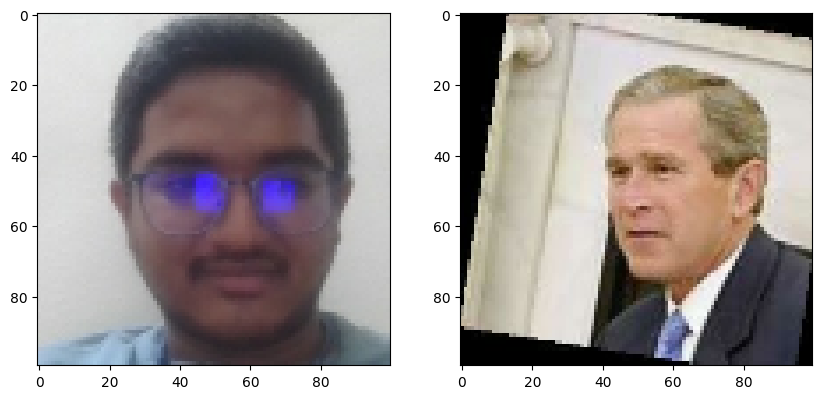

In [304]:
 plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[0])

plt.subplot(1,2,2)
plt.imshow(test_val[0])

plt.show()


In [305]:
siamese_model.save('siamesemodelv2.keras')

In [306]:
L1Dist

__main__.L1Dist

In [307]:
 siamese_model = tf.keras.models.load_model('siamesemodelv2.keras', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.keras.losses.BinaryCrossentropy})

In [308]:
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


array([[2.8528577e-05],
       [9.9734741e-01],
       [1.4688039e-06],
       [9.9854875e-01],
       [8.8203651e-01],
       [9.9879986e-01],
       [9.9649149e-01],
       [1.5225833e-06],
       [4.3793651e-07],
       [9.9967867e-01],
       [9.9580032e-01],
       [9.9973238e-01],
       [9.9624991e-01],
       [3.0104273e-05],
       [1.3654949e-07],
       [2.3319294e-07]], dtype=float32)

In [309]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distance (L1Dist)             │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier (Dense)            │ (None, 1)                 │           4,097 │ distance[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [310]:
'application_data\verification_images'

'application_data\x0berification_images'

In [311]:
os.listdir(os.path.join('application_data', 'verification_images'))

['0a0205b6-dce2-11ef-ace1-c03532408c02.jpg',
 '0a06ad6c-dce2-11ef-ab77-c03532408c02.jpg',
 '0a41d3a8-dce2-11ef-8b4a-c03532408c02.jpg',
 '0a498218-dce2-11ef-9aa5-c03532408c02.jpg',
 '0a701266-dce2-11ef-b0da-c03532408c02.jpg',
 '0a7471f0-dce2-11ef-bf21-c03532408c02.jpg',
 '0a7c637a-dce2-11ef-a455-c03532408c02.jpg',
 '0a83ba94-dce2-11ef-ad80-c03532408c02.jpg',
 '0a8a1308-dce2-11ef-86fd-c03532408c02.jpg',
 '0ab6afae-dce2-11ef-844a-c03532408c02.jpg',
 '0ac5bd00-dce2-11ef-9218-c03532408c02.jpg',
 '0ace43a8-dce2-11ef-a2dd-c03532408c02.jpg',
 '0ad6775a-dce2-11ef-922f-c03532408c02.jpg',
 '0adef1ba-dce2-11ef-a7d6-c03532408c02.jpg',
 '0af2eac8-dce2-11ef-b41d-c03532408c02.jpg',
 '0b131a22-dce2-11ef-b693-c03532408c02.jpg',
 '0b1b4dad-dce2-11ef-8839-c03532408c02.jpg',
 '0b3821fc-dce2-11ef-8c7d-c03532408c02.jpg',
 '0b3d7d5f-dce2-11ef-9d2d-c03532408c02.jpg',
 '0b49ce40-dce2-11ef-b413-c03532408c02.jpg',
 '0b5d5d6e-dce2-11ef-8dd0-c03532408c02.jpg',
 '0b95fcbb-dce2-11ef-b326-c03532408c02.jpg',
 '0ba356a4

In [312]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [313]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\0a0205b6-dce2-11ef-ace1-c03532408c02.jpg
application_data\verification_images\0a06ad6c-dce2-11ef-ab77-c03532408c02.jpg
application_data\verification_images\0a41d3a8-dce2-11ef-8b4a-c03532408c02.jpg
application_data\verification_images\0a498218-dce2-11ef-9aa5-c03532408c02.jpg
application_data\verification_images\0a701266-dce2-11ef-b0da-c03532408c02.jpg
application_data\verification_images\0a7471f0-dce2-11ef-bf21-c03532408c02.jpg
application_data\verification_images\0a7c637a-dce2-11ef-a455-c03532408c02.jpg
application_data\verification_images\0a83ba94-dce2-11ef-ad80-c03532408c02.jpg
application_data\verification_images\0a8a1308-dce2-11ef-86fd-c03532408c02.jpg
application_data\verification_images\0ab6afae-dce2-11ef-844a-c03532408c02.jpg
application_data\verification_images\0ac5bd00-dce2-11ef-9218-c03532408c02.jpg
application_data\verification_images\0ace43a8-dce2-11ef-a2dd-c03532408c02.jpg
application_data\verification_images\0ad6775a-dce2-11ef-922f-c03

In [314]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    detection = np.sum(np.array(results) > detection_threshold)
    
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [324]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('v'):

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        results, verified = verify(siamese_model, 0.5, 0.6)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━

In [325]:
np.sum(np.squeeze(results) > 0.9)

0

In [334]:
results

[array([[0.50150985]], dtype=float32),
 array([[0.501338]], dtype=float32),
 array([[0.50138414]], dtype=float32),
 array([[0.5012115]], dtype=float32),
 array([[0.5013944]], dtype=float32),
 array([[0.5015831]], dtype=float32),
 array([[0.50159085]], dtype=float32),
 array([[0.5015809]], dtype=float32),
 array([[0.5016129]], dtype=float32),
 array([[0.5015718]], dtype=float32),
 array([[0.5014895]], dtype=float32),
 array([[0.50159883]], dtype=float32),
 array([[0.5016937]], dtype=float32),
 array([[0.5018195]], dtype=float32),
 array([[0.50192887]], dtype=float32),
 array([[0.5019058]], dtype=float32),
 array([[0.50144005]], dtype=float32),
 array([[0.50102067]], dtype=float32),
 array([[0.5012162]], dtype=float32),
 array([[0.50133383]], dtype=float32),
 array([[0.5013878]], dtype=float32),
 array([[0.50159264]], dtype=float32),
 array([[0.5018183]], dtype=float32),
 array([[0.5016674]], dtype=float32),
 array([[0.50177026]], dtype=float32),
 array([[0.5017749]], dtype=float32),
 ar